![image](resources/qcqh-lab-header.png)

# Lab 6: Qubit Drive: Rabi & Ramsey Experiments

In this lab, you will take what you learned about qubit drive to perform Rabi and Ramsey experiment on a Pulse Simulator. The goal of this lab is to familiarize yourself with the important concepts of manipulating qubit states with microwave pulses.

### Installing Necessary Packages
Before we begin, you will need to install some prerequisites into your environment. Run the cell below to complete these installations. At the end, the cell outputs will be cleared.

In [1]:
!pip install -U -r resources/requirements.txt

from IPython.display import clear_output
clear_output()

## Simulating the Transmon as a Duffing Oscillator

As you learned in lectures 16 to 18, the transmon can be understood as a Duffing oscillator specified by a frequency $\nu$, anharmonicity $\alpha$, and drive strength $r$, which results in the Hamiltonian
$$
   \hat{H}_{\rm Duff}/\hbar = 2\pi\nu a^\dagger a + \pi \alpha a^\dagger a(a^\dagger a - 1) + 2 \pi r (a + a^\dagger) \times D(t),
$$

where $D(t)$ is the signal on the drive channel for the qubit, and $a^\dagger$ and $a$ are, respectively, the creation and annihilation operators for the qubit. Note that the drive strength $r$ sets the scaling of the control term, with $D(t)$ assumed to be a complex and unitless number satisfying $|D(t)| \leq 1$. 

## Qiskit Pulse Overview

As a brief overview, Qiskit Pulse schedules (experiments) consist of Instructions (i.e., Play) acting on Channels (i.e., the drive channel). Here is a summary table of available Instructions and Channels:

![image](resources/pulse-instr.png)

For more detail, this table summarizes the interaction of the channels with the actual quantum hardware:

![image](resources/pulse-user-device-layers.png)

However, we find it is more instructive to begin with guided programming in Pulse. Below you will learn how to create pulses, schedules, and run experiments on a simulator. These lessons can be immediately applied to actual pulse-enabled quantum hardware, in particular [`ibmq_armonk`](https://www.ibm.com/blogs/research/2019/12/qiskit-openpulse/).

## Let's get started!

In most of the cells below, nothing needs to be modified. **However, you will need to execute the cells by pressing `shift+Enter` in each code block**. In order to keep things tidy and focus on the important aspects of Qiskit Pulse, the following cells make use of methods from the `helper` module. For the gory details, please refer back to the [Lab 6 notebook](lab6-drive-ham-rabi-ramsey.ipynb). Before coming to Exercise 1a, the following code blocks

- create backend pulse simulator and instantiate the transmon as a Duffing oscillator of frequency $\sim 5$ GHz
- import libraries for numerics and visualization, and define helpful constants
- create the channels for the pulse schedule and define measurment schedule (we will only work with the drive channel)

In [2]:
# our backend is the Pulse Simulator
from resources import helper
from qiskit.providers.aer import PulseSimulator
backend_sim = PulseSimulator()

# sample duration for pulse instructions 
dt = 1e-9

# create the model
duffing_model = helper.get_transmon(dt)

# get qubit frequency from Duffing model
qubit_lo_freq = duffing_model.hamiltonian.get_qubit_lo_from_drift()

In [3]:
import numpy as np

# visualization tools
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
kHz = 1.0e3 # kilohertz
us = 1.0e-6 # microseconds
ns = 1.0e-9 # nanoseconds

### Instantiate channels and create measurement schedule

We will use the same measurement schedule throughout, whereas the drive schedules will vary. This must be built for the simulator, for a real backend we can ask for its default measurement pulse.

In [4]:
from qiskit import pulse
from qiskit.pulse import Play, Acquire
from qiskit.pulse.library import GaussianSquare

# qubit to be used throughout the notebook
qubit = 0

### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

# Construct a measurement schedule and add it to an InstructionScheduleMap
meas_samples = 1200
meas_pulse = GaussianSquare(duration=meas_samples, amp=0.025, sigma=4, width=1150)
measure_sched = Play(meas_pulse, meas_chan) | Acquire(meas_samples, acq_chan, pulse.MemorySlot(qubit))

inst_map = pulse.InstructionScheduleMap()
inst_map.add('measure', [qubit], measure_sched)

# save the measurement/acquire pulse for later
measure = inst_map.get('measure', qubits=[qubit])

## Graded Exercise 1a: Rabi Schedule

Add code to the method below in order to build a Rabi pulse schedule. A Rabi experiment consists of a drive pulse at the qubit frequency, followed by a measurement. A list of Rabis schedules will vary the drive amplitude each time. For a review of creating pulse schedules, see [Lab 6 notebook](lab6-drive-ham-rabi-ramsey.ipynb).

In [5]:
from qiskit.pulse.library import Gaussian

def build_rabi_pulse_schedule(drive_duration, drive_amp, drive_sigma):
    ### create a Rabi schedule (already done)
    ### create a Gaussian Rabi pulse using the pulse library
    ### play Rabi pulse on the Rabi schedule and return
    
    rabi_schedule = pulse.Schedule(name='rabi_experiment')
    
    ### WRITE YOUR CODE BETWEEN THESE LINES - START
    
    rabi_pulse = Gaussian(duration=drive_duration, amp=drive_amp, sigma=drive_sigma)
    rabi_schedule += Play(rabi_pulse, drive_chan)
    
    ### WRITE YOUR CODE BETWEEN THESE LINES - END
    
    # add measurement to rabi_schedule
    # << indicates time shift the beginning to the start of the schedule
    rabi_schedule += measure << rabi_schedule.duration
    return rabi_schedule

### From the Rabi schedule of Exercise 1a, create a list of schedules for the experiment

In [6]:
# Gaussian pulse parameters, with varying amplitude
drive_duration = 128
num_rabi_points = 41
drive_amps = np.linspace(0, 0.9, num_rabi_points)
drive_sigma = 16

# now vary the amplitude for each drive amp
rabi_schedules = []
for drive_amp in drive_amps:
    rabi_schedules.append(build_rabi_pulse_schedule(drive_duration, drive_amp, drive_sigma))

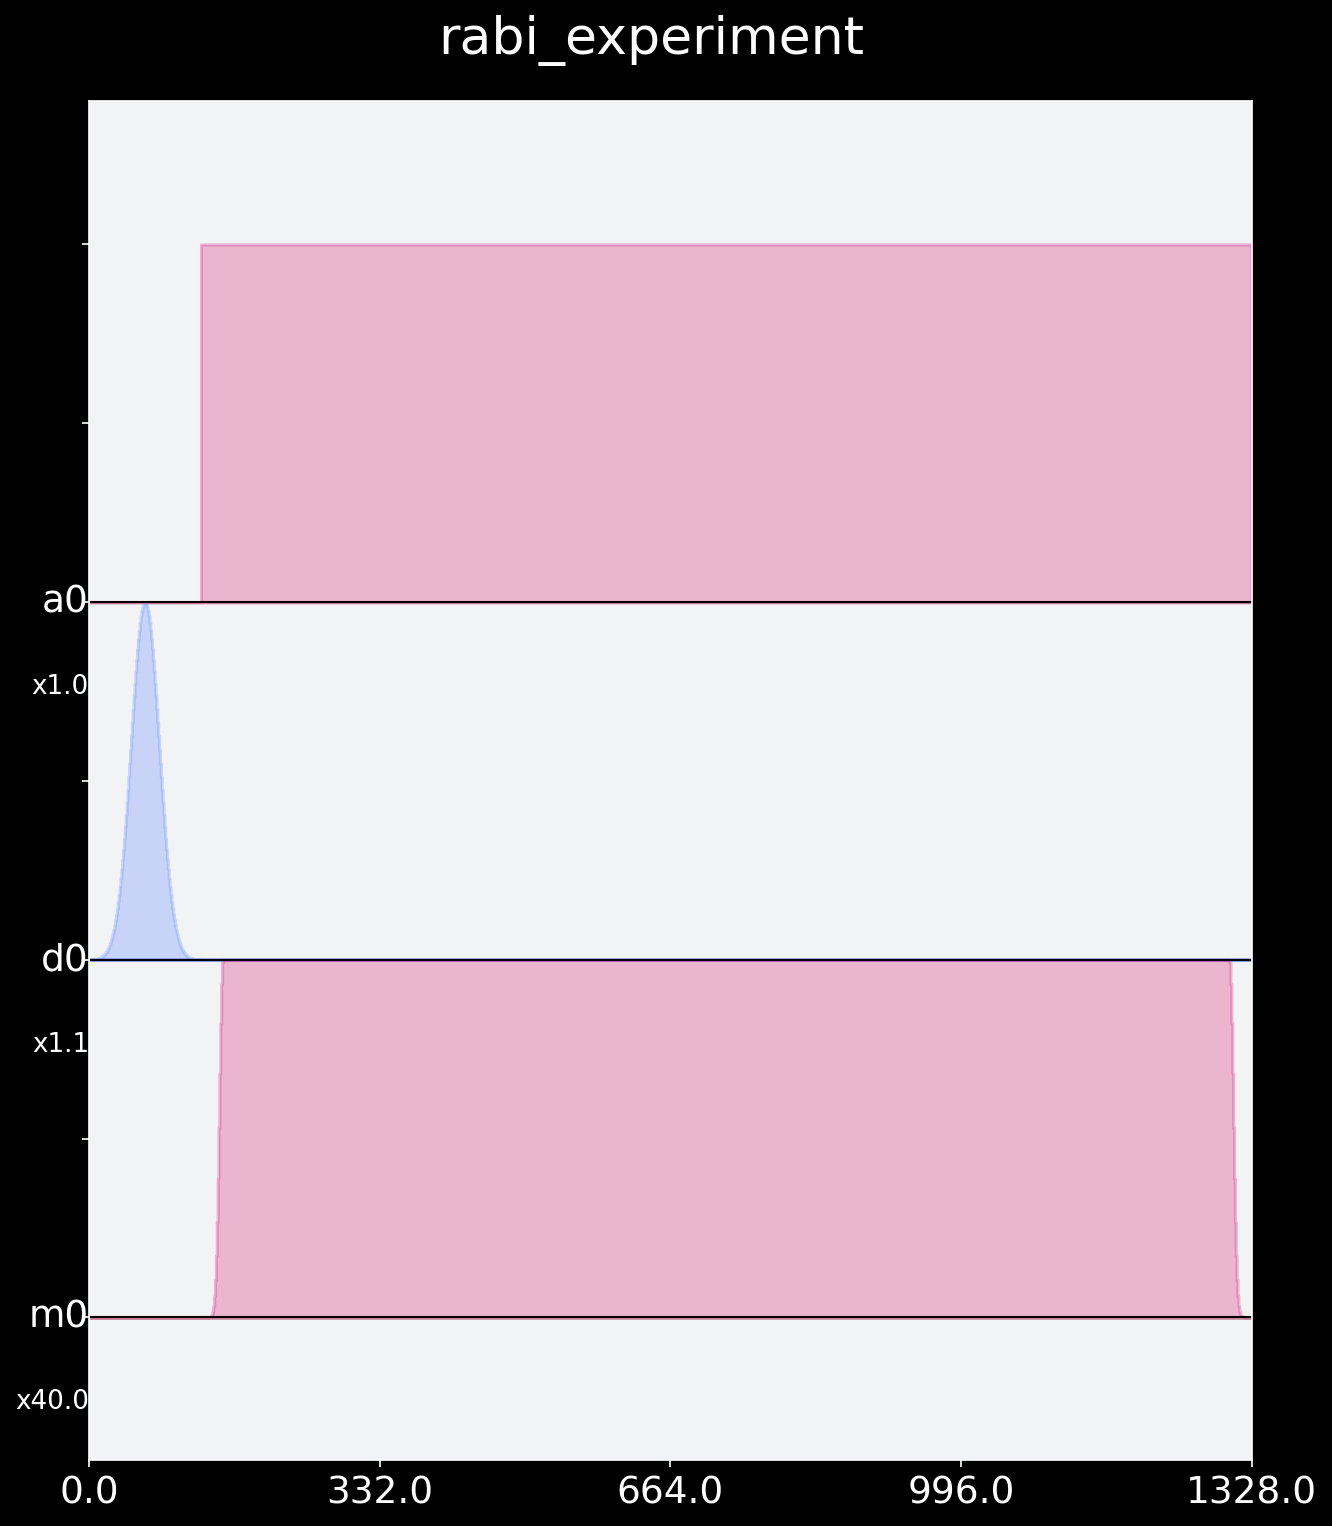

In [7]:
rabi_schedules[-1].draw() 

In [8]:
# assemble the schedules into a Qobj
from qiskit import assemble

rabi_qobj = assemble(**helper.get_params('rabi', globals()))
clear_output()

In [9]:
# run the simulation
rabi_result = backend_sim.run(rabi_qobj, duffing_model).result()

In [10]:
# retrieve the data from the experiment
rabi_values = helper.get_values_from_result(rabi_result, qubit)

### Fit Results and Plot Rabi Experiment
Once the rough frequency of the qubit is know, the Rabi experiment determines the amplitude of a $\pi$-pulse, that is, the strength of a pulse needed to rotate the qubit around the Bloch sphere from the $|0\rangle$ to $|1\rangle$ states (or vice versa). We assume the rotation axis to be the $x$-axis.

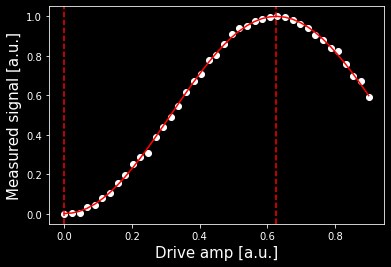

Pi pulse amplitude is 0.624660


In [11]:
fit_params, y_fit = helper.fit_sinusoid(drive_amps, rabi_values, [1, 0, 0.5, 0])

plt.scatter(drive_amps, rabi_values, color='white')
plt.plot(drive_amps, y_fit, color='red')

drive_period = fit_params[2] # get period of rabi oscillation

plt.axvline(0, color='red', linestyle='--')
plt.axvline(drive_period/2, color='red', linestyle='--')
plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

print("Pi pulse amplitude is %f"%float(drive_period/2))

The $\pi$ pulse amplitude is half the period of the sinusoid (a full period of $360^\circ$ brings it back to zero, but we wish to take the qubit from the zero to one state). For the following experiment, we want a $\pi/2$ pulse: we wish to place the qubit on the equator of the Bloch sphere. The following creates a pulse that rotates the qubit $\pi/2$ ($90^\circ$ degrees) around the Bloch sphere:

In [12]:
# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
x90_pulse = Gaussian(duration=drive_duration,
                               amp=drive_period/4, 
                               sigma=drive_sigma,
                               name='x90_pulse')

## Ramsey Experiment

The Ramsey experiment reveals the time dynamics of driving the qubit off-resonantly. In particular, we vary the delay between two $\pi/2$-pulses.

In [13]:
# Ramsey experiment parameters
time_max_us = 0.4
time_step_us = 0.0035
times_us = np.arange(0.1, time_max_us, time_step_us)
# Convert to units of dt
delay_times_dt = times_us * us / dt

## Graded Exercise 1b: Ramsey Schedule

Add code to the method below in order to build a Ramsey pulse schedule. For a review of creating pulse schedules, see [the Qiskit Textbook's section on calibrating qubits](https://qiskit.org/textbook/ch-quantum-hardware/calibrating-qubits-pulse.html).

In [14]:
def build_ramsey_pulse_schedule(delay):
    ### create a Ramsey pulse schedule (already done)
    ### play an x90 pulse on the drive channel
    ### play another x90 pulse after delay
    ### add measurement pulse to schedule
    
    ramsey_schedule = pulse.Schedule(name='ramsey_experiment')
    
    ### HINT: include delay by adding it to the duration of the schedule
    ###       round delay to nearest integer with int(delay)
    
    ### WRITE YOUR CODE BETWEEN THESE LINES - START
    from qiskit.pulse import Delay

    ramsey_schedule += Play(x90_pulse, drive_chan)
    ramsey_schedule += Delay(int(delay), drive_chan)
    ramsey_schedule += Play(x90_pulse, drive_chan)
    ramsey_schedule += measure << ramsey_schedule.duration
    
    ### WRITE YOUR CODE BETWEEN THESE LINES - END
    
    return ramsey_schedule

In [15]:
# create schedules for Ramsey experiment 
ramsey_schedules = []
for delay in delay_times_dt:
    ramsey_schedules.append(build_ramsey_pulse_schedule(delay))

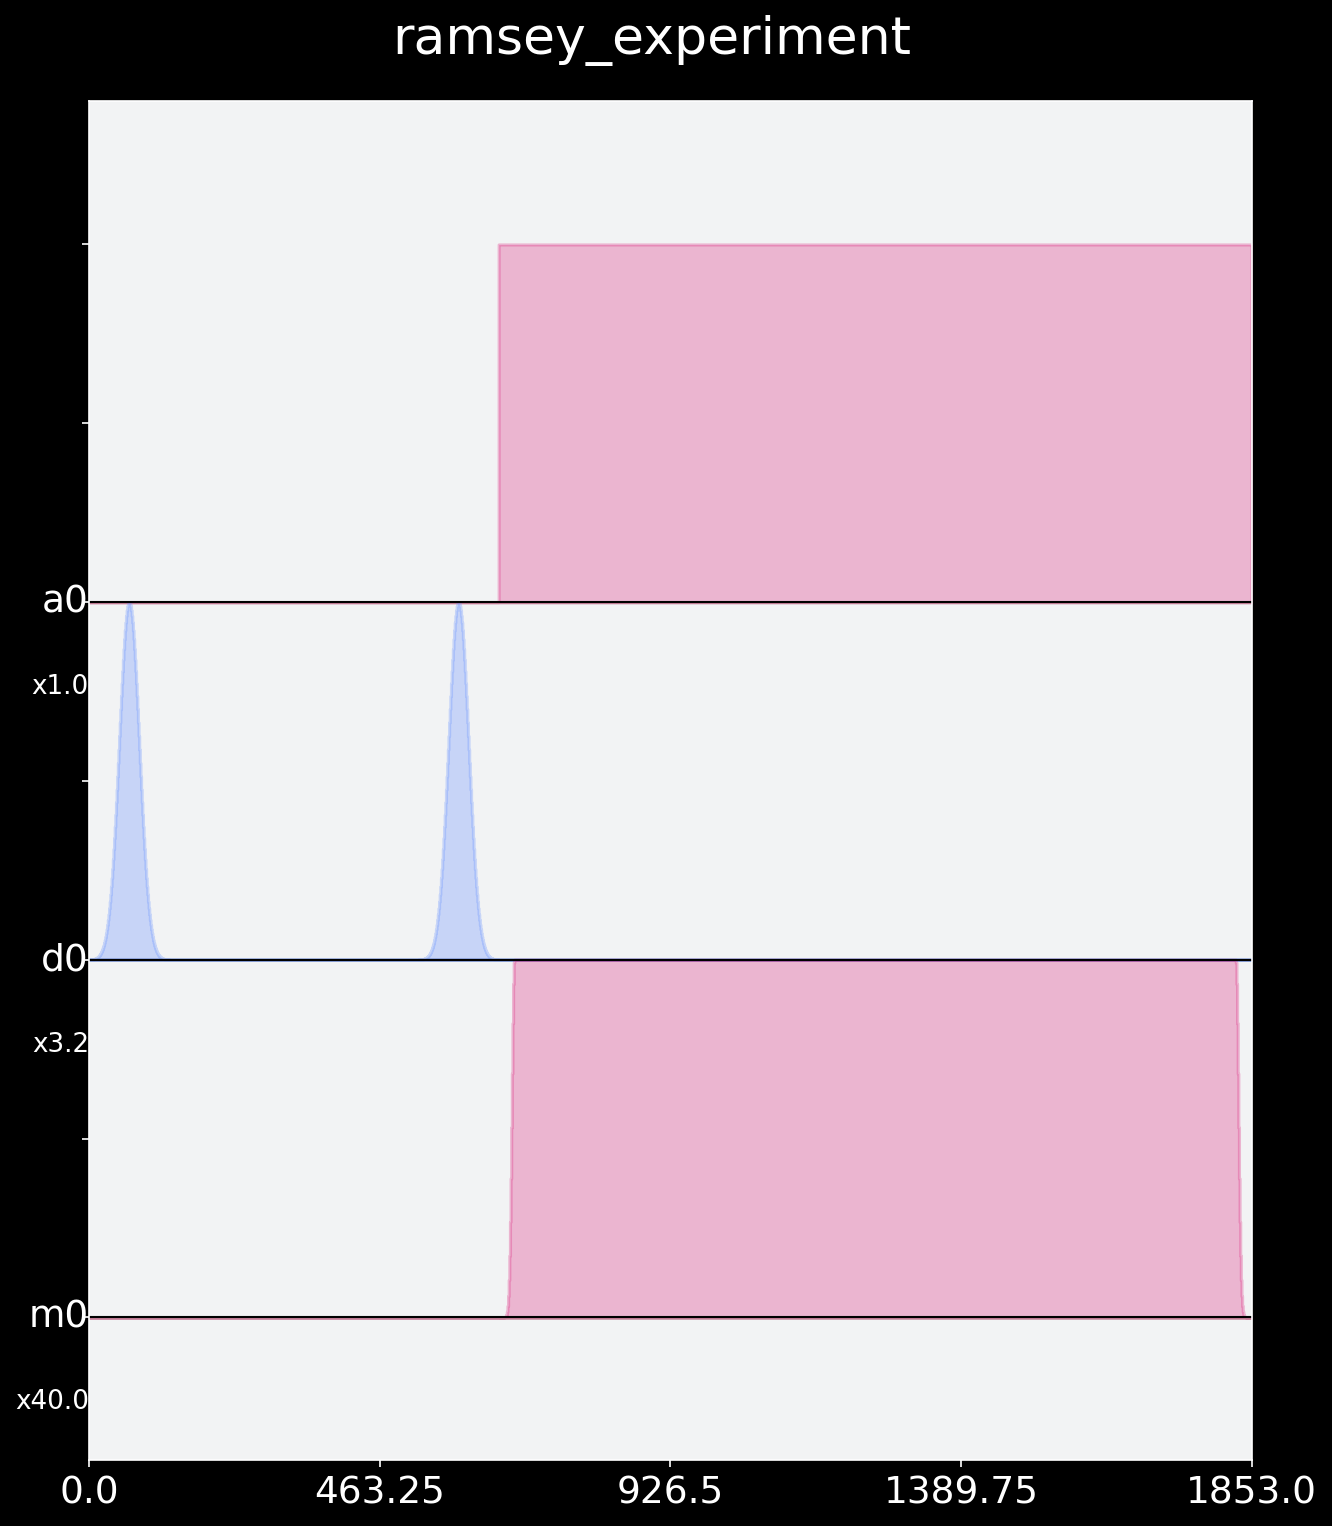

In [16]:
ramsey_schedules[-1].draw()

In [17]:
# assemble the schedules into a Qobj
# the helper will drive the pulses off-resonantly by an unknown value
ramsey_qobj = assemble(**helper.get_params('ramsey', globals()))
clear_output()

In [18]:
# run the simulation
ramsey_result = backend_sim.run(ramsey_qobj, duffing_model).result()

In [19]:
# retrieve the data from the experiment
ramsey_values = helper.get_values_from_result(ramsey_result, qubit)

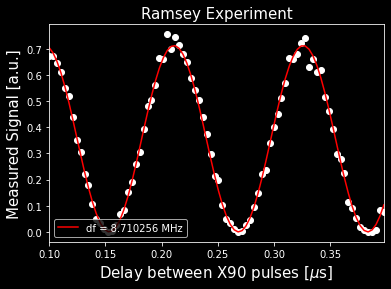

Drive is off-resonant by 8.710256 MHz


In [20]:
# off-resonance component
fit_params, y_fit = helper.fit_sinusoid(times_us, ramsey_values, [1, 0.7, 0.1, 0.25])
_, _, ramsey_period_us, _, = fit_params 
del_f_MHz = 1/ramsey_period_us # freq is MHz since times in us

plt.scatter(times_us, np.real(ramsey_values), color='white')
plt.plot(times_us, y_fit, color='red', label=f"df = {del_f_MHz:.6f} MHz")
plt.xlim(np.min(times_us), np.max(times_us))
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Ramsey Experiment', fontsize=15)
plt.legend(loc=3)
plt.show()

print("Drive is off-resonant by %f MHz"%float(del_f_MHz))

# Additional Resources

- The Qiskit textbook sections that cover this material are
  - [Introduction to Transmon Physics](https://qiskit.org/textbook/ch-quantum-hardware/transmon-physics.html)
  - [Calibrating Qubits with Qiskit Pulse](https://qiskit.org/textbook/ch-quantum-hardware/calibrating-qubits-openpulse.html)

- Watch the videos
  - [Quantum Coding with Lauren Capelluto](https://www.youtube.com/watch?v=ZvipHRY-URs)
  - ["Qiskit Pulse: Programming Quantum Computers Through the Cloud with Pulses"](https://www.youtube.com/watch?v=V_as5PufUiU) webinar at CQT by Nicholas Bronn